In [1]:
#import moudule and ML mouy

# pandas
import pandas as pd
from pandas import Series, DataFrame

# numpy, matplotlib, seaborn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

# machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

In [2]:
train_df = pd.read_csv("./data/titanic_train.csv")
test_df  = pd.read_csv("./data/titanic_test.csv")

# preview the data
train_df.head()

PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S

In [3]:
# see nan 
train_df.info()
print("*--------------------*")
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB
*--------------------*
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare      

## Feature Engineering:

The features in your data are important to the predictive models you use which will influence your the results.

The nature of the data is that it contains many features that may be either *redundant* or *irrelevant*. Redundant feature has values that can be predicted from another feature(in other words, provides you with almost the same information), while a relevant feature is strongly correlated.

**Feature selection** methods can be used to identify and remove irrelevant and redundant features from data, hopefully, without affecting the accuracy of a predictive model.

There are three main categories of feature selection algorithms: 

- Wrapper Methods: Evaluation of each possible subset against a model, and see which one will give you a better accuracy(less error rate).
- Filter Methods: Filter features by their correlation score between the feature and the label(the variable you want to predict). The higher the correlation, the higher the relevance of the feature. You can also measure the correlation or the dependency between the two features, and if they are highly dependent, then, it's an indication of redundancy.
- Embedded Methods: There are models that learn which features best contribute to the accuracy of the model. These models compute feature importance, which in turn can be used to discard unimportant features.

References:
https://en.wikipedia.org/wiki/Feature_engineering

https://en.wikipedia.org/wiki/Feature_selection

http://machinelearningmastery.com/an-introduction-to-feature-selection/

http://scikit-learn.org/stable/modules/feature_selection.html

In [4]:
# dropout some unnecessary
train_df = train_df.drop(['PassengerId','Name','Ticket'], axis=1)
test_df  = test_df.drop(['Name','Ticket'], axis=1)

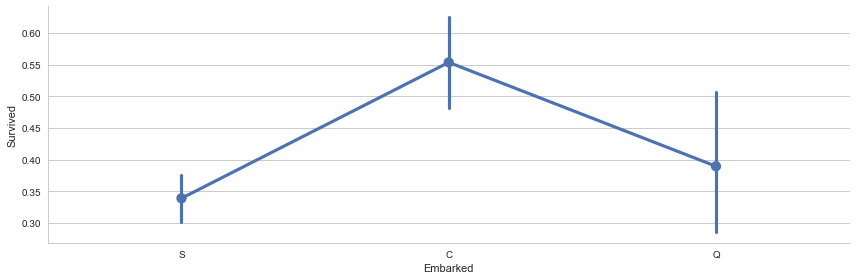

In [5]:
# Embarked       889 non-null object, means 2 null value, fill "S"
train_df["Embarked"] = train_df["Embarked"].fillna("S")

# plot
sns.factorplot('Embarked','Survived', data=train_df, size=4, aspect=3)

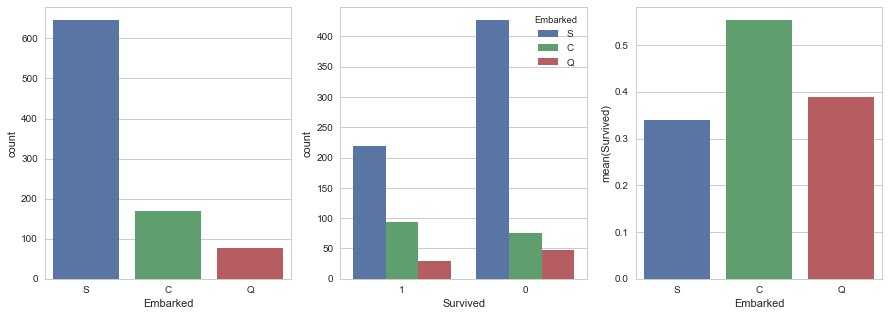

In [6]:
fig, ax = plt.subplots(1,3,figsize=(15,5))

sns.countplot(x='Embarked', data=train_df, ax=ax[0])
sns.countplot(x='Survived', hue="Embarked", data=train_df, order=[1,0], ax=ax[1])

# group by embarked, and get the mean for survived passengers for each value in Embarked
embark_perc = train_df[["Embarked", "Survived"]].groupby(['Embarked'], as_index=False).mean()
sns.barplot(x='Embarked', y='Survived', data=embark_perc, order=['S','C','Q'], ax=ax[2])

In [7]:
# Either to consider Embarked column in predictions,
# and remove "S" dummy variable, 
# and leave "C" & "Q", since they seem to have a good rate for Survival.

# OR, don't create dummy variables for Embarked column, just drop it, 
# because logically, Embarked doesn't seem to be useful in prediction.

embark_dummies_titanic  = pd.get_dummies(train_df['Embarked'])
embark_dummies_titanic.drop(['S'], axis=1, inplace=True)

embark_dummies_test  = pd.get_dummies(test_df['Embarked'])
embark_dummies_test.drop(['S'], axis=1, inplace=True)

train_df = train_df.join(embark_dummies_titanic)
test_df  = test_df.join(embark_dummies_test)

train_df.drop(['Embarked'], axis=1,inplace=True)
test_df.drop(['Embarked'], axis=1,inplace=True)

In [8]:
train_df.head()

Survived  Pclass     Sex   Age  SibSp  Parch     Fare Cabin  C  Q
0         0       3    male  22.0      1      0   7.2500   NaN  0  0
1         1       1  female  38.0      1      0  71.2833   C85  1  0
2         1       3  female  26.0      0      0   7.9250   NaN  0  0
3         1       1  female  35.0      1      0  53.1000  C123  0  0
4         0       3    male  35.0      0      0   8.0500   NaN  0  0

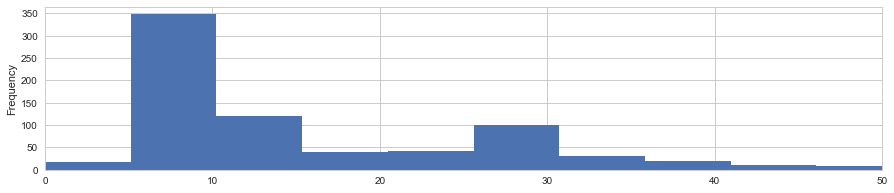

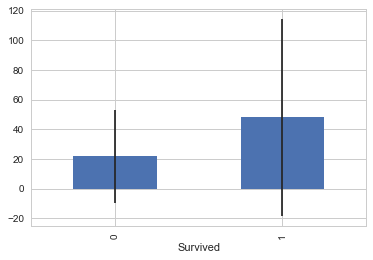

In [9]:
# Fare

# only for test_df, since there is a missing "Fare" values
test_df["Fare"].fillna(test_df["Fare"].median(), inplace=True)

# convert from float to int
train_df['Fare'] = train_df['Fare'].astype(int)
test_df['Fare']  = test_df['Fare'].astype(int)

# get fare for survived & didn't survive passengers 
fare_not_survived = train_df["Fare"][train_df["Survived"] == 0]
fare_survived     = train_df["Fare"][train_df["Survived"] == 1]

# get average and std for fare of survived/not survived passengers
avgerage_fare = DataFrame([fare_not_survived.mean(), fare_survived.mean()])
std_fare      = DataFrame([fare_not_survived.std(), fare_survived.std()])

# plot
train_df['Fare'].plot(kind='hist', figsize=(15,3), bins=100, xlim=(0,50))

avgerage_fare.index.names = std_fare.index.names = ["Survived"]
avgerage_fare.plot(yerr=std_fare,kind='bar',legend=False)

In [10]:
# Age 
# train: Age 714 non-null of 891
# test:  Age 332 non-null of 418 entries,

# get average, std, and number of NaN values in titanic_df
average_age_titanic   = train_df["Age"].mean()
std_age_titanic       = train_df["Age"].std()
count_nan_age_titanic = train_df["Age"].isnull().sum()

# get average, std, and number of NaN values in test_df
average_age_test   = test_df["Age"].mean()
std_age_test       = test_df["Age"].std()
count_nan_age_test = test_df["Age"].isnull().sum()

print(average_age_titanic, "\n", average_age_test)

29.6991176471 
 30.2725903614


In [11]:
# generate random numbers between (mean - std) & (mean + std)
rand_1 = np.random.randint(average_age_titanic - std_age_titanic, 
                           average_age_titanic + std_age_titanic, size = count_nan_age_titanic)
rand_2 = np.random.randint(average_age_test - std_age_test, 
                           average_age_test + std_age_test, size = count_nan_age_test)

/Users/lang/anaconda3/envs/ml/lib/python3.6/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/lang/anaconda3/envs/ml/lib/python3.6/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


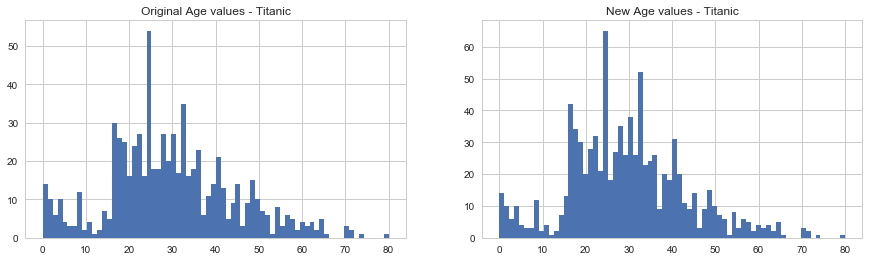

In [12]:
fig, ax = plt.subplots(1,2,figsize=(15,4))
ax[0].set_title('Original Age values - Titanic')
ax[1].set_title('New Age values - Titanic')

#fig, ax = plt.subplots(2,2,figsize=(15,4))
#ax[0][0].set_title('Original Age values - Titanic')
#ax[0][1].set_title('New Age values - Titanic')
#ax[1][0].set_title('Original Age values - Test')
#ax[1][1].set_title('New Age values - Test')


# plot original Age values
# NOTE: drop all null values, and convert to int
train_df['Age'].dropna().astype(int).hist(bins=70, ax=ax[0])
# test_df['Age'].dropna().astype(int).hist(bins=70, ax=axis1)

# fill NaN values in Age column with random values generated
train_df["Age"][np.isnan(train_df["Age"])] = rand_1
test_df["Age"][np.isnan(test_df["Age"])]   = rand_2

# convert from float to int
train_df['Age'] = train_df['Age'].astype(int)
test_df['Age']  = test_df['Age'].astype(int)
        
# plot new Age Values
train_df['Age'].hist(bins=70, ax=ax[1])
# test_df['Age'].hist(bins=70, ax=axis4)

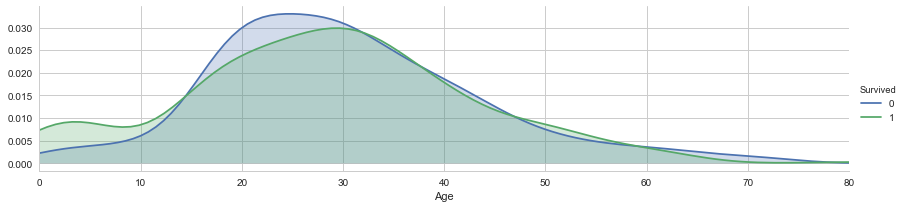

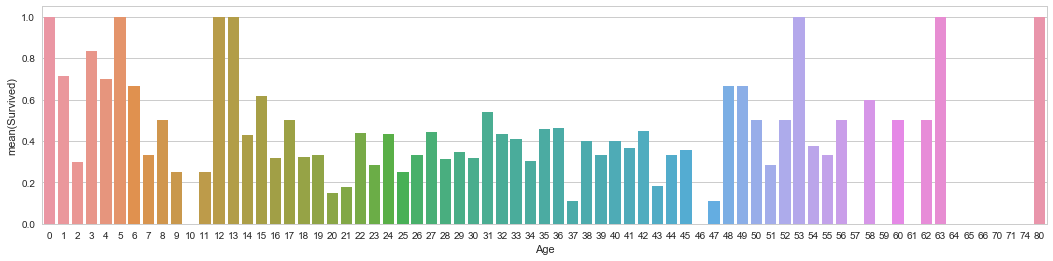

In [13]:
# peaks for survived/not survived passengers by their age
facet = sns.FacetGrid(train_df, hue="Survived",aspect=4)
facet.map(sns.kdeplot,'Age',shade= True)
facet.set(xlim=(0, train_df['Age'].max()))
facet.add_legend()

# average survived passengers by age
fig, axis1 = plt.subplots(1,1,figsize=(18,4))
average_age = train_df[["Age", "Survived"]].groupby(['Age'],as_index=False).mean()
sns.barplot(x='Age', y='Survived', data=average_age)

In [14]:
# Cabin
# It has a lot of NaN values, so it won't cause a remarkable impact on prediction
train_df.drop("Cabin",axis=1,inplace=True)
test_df.drop("Cabin",axis=1,inplace=True)

/Users/lang/anaconda3/envs/ml/lib/python3.6/site-packages/pandas/core/indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


[<matplotlib.text.Text at 0x1194b4630>, <matplotlib.text.Text at 0x1194c04a8>]

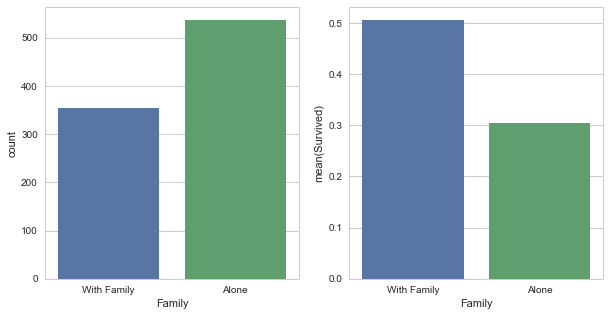

In [15]:
train_df['Family'] =  train_df["Parch"] + train_df["SibSp"]
train_df['Family'].loc[train_df['Family'] > 0] = 1 # 
train_df['Family'].loc[train_df['Family'] == 0] = 0

test_df['Family'] =  test_df["Parch"] + test_df["SibSp"]
test_df['Family'].loc[test_df['Family'] > 0] = 1
test_df['Family'].loc[test_df['Family'] == 0] = 0

# drop Parch & SibSp
train_df = train_df.drop(['SibSp','Parch'], axis=1)
test_df    = test_df.drop(['SibSp','Parch'], axis=1)

# plot
fig, (axis1,axis2) = plt.subplots(1,2,sharex=True,figsize=(10,5))

# sns.factorplot('Family',data=titanic_df,kind='count',ax=axis1)
sns.countplot(x='Family', data=train_df, order=[1,0], ax=axis1)

# average of survived for those who had/didn't have any family member
family_perc = train_df[["Family", "Survived"]].groupby(['Family'],as_index=False).mean()
sns.barplot(x='Family', y='Survived', data=family_perc, order=[1,0], ax=axis2)

axis1.set_xticklabels(["With Family","Alone"], rotation=0)

In [16]:
train_df.head()

Survived  Pclass     Sex  Age  Fare  C  Q  Family
0         0       3    male   22     7  0  0       1
1         1       1  female   38    71  1  0       1
2         1       3  female   26     7  0  0       0
3         1       1  female   35    53  0  0       1
4         0       3    male   35     8  0  0       0

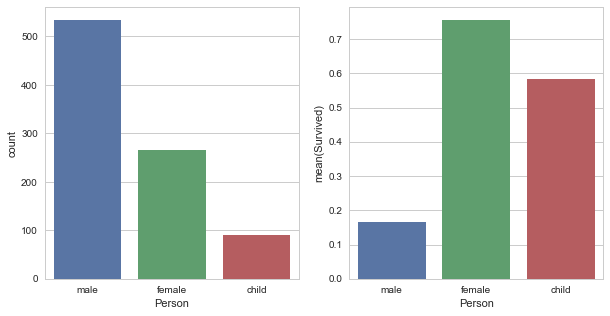

In [17]:
# Sex

# As we see, children(age < ~16) on aboard seem to have a high chances for Survival.
# So, we can classify passengers as males, females, and child
def get_person(passenger):
    age, sex = passenger
    return 'child' if age < 16 else sex
    
train_df['Person'] = train_df[['Age','Sex']].apply(get_person,axis=1) # apply function
test_df['Person']  = test_df[['Age','Sex']].apply(get_person,axis=1)

# No need to use Sex column since we created Person column
train_df.drop(['Sex'],axis=1,inplace=True)
test_df.drop(['Sex'],axis=1,inplace=True)

# create dummy variables for Person column, & drop Male as it has the lowest average of survived passengers
person_dummies_titanic  = pd.get_dummies(train_df['Person'])
person_dummies_titanic.columns = ['Child','Female','Male']
person_dummies_titanic.drop(['Male'], axis=1, inplace=True)

person_dummies_test  = pd.get_dummies(test_df['Person'])
person_dummies_test.columns = ['Child','Female','Male']
person_dummies_test.drop(['Male'], axis=1, inplace=True)

train_df = train_df.join(person_dummies_titanic)
test_df    = test_df.join(person_dummies_test)

fig, (axis1,axis2) = plt.subplots(1,2,figsize=(10,5))

# sns.factorplot('Person',data=titanic_df,kind='count',ax=axis1)
sns.countplot(x='Person', data=train_df, ax=axis1)

# average of survived for each Person(male, female, or child)
person_perc = train_df[["Person", "Survived"]].groupby(['Person'],as_index=False).mean()
sns.barplot(x='Person', y='Survived', data=person_perc, ax=axis2, order=['male','female','child'])

train_df.drop(['Person'],axis=1,inplace=True)
test_df.drop(['Person'],axis=1,inplace=True)

In [18]:
train_df.head()

Survived  Pclass  Age  Fare  C  Q  Family  Child  Female
0         0       3   22     7  0  0       1      0       0
1         1       1   38    71  1  0       1      0       1
2         1       3   26     7  0  0       0      0       1
3         1       1   35    53  0  0       1      0       1
4         0       3   35     8  0  0       0      0       0

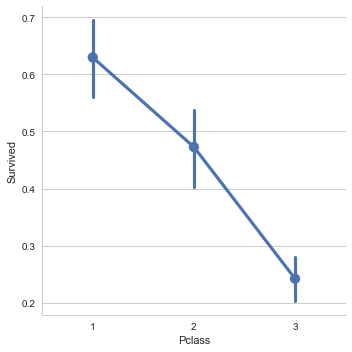

In [19]:
# Pclass

# sns.factorplot('Pclass',data=titanic_df,kind='count',order=[1,2,3])
sns.factorplot('Pclass','Survived',order=[1,2,3], data=train_df,size=5)

In [20]:
# create dummy variables for Pclass column, & drop 3rd class as it has the lowest average of survived passengers
pclass_dummies_titanic  = pd.get_dummies(train_df['Pclass'])
pclass_dummies_titanic.columns = ['Class_1','Class_2','Class_3']
pclass_dummies_titanic.drop(['Class_3'], axis=1, inplace=True) # class 3 low probability survived

pclass_dummies_test  = pd.get_dummies(test_df['Pclass'])
pclass_dummies_test.columns = ['Class_1','Class_2','Class_3']
pclass_dummies_test.drop(['Class_3'], axis=1, inplace=True) 

train_df.drop(['Pclass'],axis=1,inplace=True)
test_df.drop(['Pclass'],axis=1,inplace=True)

train_df = train_df.join(pclass_dummies_titanic)
test_df  = test_df.join(pclass_dummies_test)

In [21]:
train_df.head()

Survived  Age  Fare  C  Q  Family  Child  Female  Class_1  Class_2
0         0   22     7  0  0       1      0       0        0        0
1         1   38    71  1  0       1      0       1        1        0
2         1   26     7  0  0       0      0       1        0        0
3         1   35    53  0  0       1      0       1        1        0
4         0   35     8  0  0       0      0       0        0        0

In [22]:
test_df.head()

PassengerId  Age  Fare  C  Q  Family  Child  Female  Class_1  Class_2
0          892   34     7  0  1       0      0       0        0        0
1          893   47     7  0  0       1      0       1        0        0
2          894   62     9  0  1       0      0       0        0        1
3          895   27     8  0  0       0      0       0        0        0
4          896   22    12  0  0       1      0       1        0        0

In [32]:
# define training and testing sets
X_train = train_df.drop("Survived",axis=1)
Y_train = train_df["Survived"]
X_test  = test_df.drop("PassengerId",axis=1).copy()

In [33]:
X_train.head()

Age  Fare  C  Q  Family  Child  Female  Class_1  Class_2
0   22     7  0  0       1      0       0        0        0
1   38    71  1  0       1      0       1        1        0
2   26     7  0  0       0      0       1        0        0
3   35    53  0  0       1      0       1        1        0
4   35     8  0  0       0      0       0        0        0

In [34]:
Y_train.head()

0    0
1    1
2    1
3    1
4    0
Name: Survived, dtype: int64

In [36]:
# Logistic Regression

logreg = LogisticRegression()

logreg.fit(X_train, Y_train)

Y_pred = logreg.predict(X_test)

logreg.score(X_train, Y_train)

0.8058361391694725

In [39]:
# Logistic Regression, but dropout fare

logreg = LogisticRegression()
X_train2 = X_train.drop('Fare', axis=1)
X_test2 = X_test.drop('Fare', axis=1).copy()
logreg.fit(X_train2, Y_train)

Y_pred = logreg.predict(X_test2)

logreg.score(X_train2, Y_train)

0.8058361391694725

In [38]:
X_train2.head()

Age  C  Q  Family  Child  Female  Class_1  Class_2
0   22  0  0       1      0       0        0        0
1   38  1  0       1      0       1        1        0
2   26  0  0       0      0       1        0        0
3   35  0  0       1      0       1        1        0
4   35  0  0       0      0       0        0        0

In [40]:
# Support Vector Machines

svc = SVC()

svc.fit(X_train, Y_train)

Y_pred = svc.predict(X_test)

svc.score(X_train, Y_train)

0.84175084175084181

In [42]:
# Random Forests

random_forest = RandomForestClassifier(n_estimators=100)

random_forest.fit(X_train, Y_train)

Y_pred = random_forest.predict(X_test)

random_forest.score(X_train, Y_train)

0.96745230078563416

In [ ]:
# upper one is overfitting?

In [ ]:
## what's difference decision tree and Random forests

In [43]:
# decision tree

from sklearn import tree
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train, Y_train)
Y_pred = clf.predict(X_test)
clf.score(X_train, Y_train)

0.96745230078563416

In [53]:
from sklearn import cross_validation

/Users/lang/anaconda3/envs/ml/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [54]:
cross_validation.train_test_split?

In [55]:
from sklearn import cross_validation
X_train3, X_test3, Y_train3, Y_test3 = cross_validation.train_test_split(X_train, Y_train, test_size=0.15)

In [57]:
# Random Forests, use difference data sets

random_forest = RandomForestClassifier(n_estimators=100)

random_forest.fit(X_train3, Y_train3)

Y_pred = random_forest.predict(X_test3)

random_forest.score(X_test3, Y_test3) # use test set accuracy will low than use train set to traning 

0.84328358208955223

In [44]:
# kNN
knn = KNeighborsClassifier(n_neighbors = 3)

knn.fit(X_train, Y_train)

Y_pred = knn.predict(X_test)

knn.score(X_train, Y_train)

0.81705948372615034

In [45]:
# kNN = 5
knn = KNeighborsClassifier(n_neighbors = 5)

knn.fit(X_train, Y_train)

Y_pred = knn.predict(X_test)

knn.score(X_train, Y_train)

0.7912457912457912

In [46]:
# kNN = 1
knn = KNeighborsClassifier(n_neighbors = 1)

knn.fit(X_train, Y_train)

Y_pred = knn.predict(X_test)

knn.score(X_train, Y_train)

0.95959595959595956

In [ ]:
## kNN selection affection the result?

In [47]:
# Gaussian Naive Bayes

gaussian = GaussianNB()

gaussian.fit(X_train, Y_train)

Y_pred = gaussian.predict(X_test)

gaussian.score(X_train, Y_train)

0.76430976430976427

## Correlation Coefficient

Correlation Coefficient: is a coefficient that illustrates a quantitative measure of some type of correlation and dependence, meaning statistical relationships between two or more random variables or observed data values.
shows the variation of dataset values(original) from the regression line. The higher the coefficient, the lower the variation from the regression line.

Feature Importance shows how much the model fit decreases when you drop a feature. When you drop a feature, The more the model fit decreases, the more significant and informative the feature. The "model fit" refers to the accuracy of the prediction values(i.e. regression line).

In [50]:
DataFrame(train_df.columns.delete(0))

0
0      Age
1     Fare
2        C
3        Q
4   Family
5    Child
6   Female
7  Class_1
8  Class_2

In [23]:
# get Correlation Coefficient for each feature using Logistic Regression
coeff_df = DataFrame(train_df.columns.delete(0))
coeff_df.columns = ['Features']
coeff_df["Coefficient Estimate"] = pd.Series(logreg.coef_[0])

# preview
coeff_df

Features  Coefficient Estimate
0      Age             -0.023868
1     Fare              0.000926
2        C              0.599748
3        Q              0.292670
4   Family             -0.239806
5    Child              1.850197
6   Female              2.774348
7  Class_1              2.031405
8  Class_2              1.109266

In [24]:
submission = pd.DataFrame({
        "PassengerId": test_df["PassengerId"],
        "Survived": Y_pred
    })
submission.to_csv('./data/titanic_result.csv', index=False)

In [51]:
!head ./data/titanic_result.csv

PassengerId,Survived
892,0
893,1
894,0
895,0
896,1
897,0
898,0
899,0
900,1


In [ ]:
ref to: https://www.kaggle.com/omarelgabry/a-journey-through-titanic
        
        a very good reference and study, espeially the comments

In [ ]:
https://zhuanlan.zhihu.com/p/27424282

In [ ]:
https://www.kaggle.com/arthurtok/introduction-to-ensembling-stacking-in-python

In [ ]:
https://www.kaggle.com/wikaiqi/titaniclearningqi

In [ ]:
Study of Tree and Forest algorithms

https://www.kaggle.com/creepykoala/study-of-tree-and-forest-algorithms
    
    
    XGBoost example (Python)

forked from XGBoost example (Python) by DataCanary (+0/â€“0)
https://www.kaggle.com/cbrogan/xgboost-example-python/code

In [ ]:
## future work: 
1. emb
2. [Coefficient of determination](https://en.wikipedia.org/wiki/Coefficient_of_determination)